In [1]:
import numpy as np
import pandas as pd 
import PIL.Image as Image

## CheXpert Dataset Analysis

In [2]:
## load the annotation file
train_file = pd.read_csv("CheXpert-v1.0-small/train.csv")
val_file = pd.read_csv("CheXpert-v1.0-small/valid.csv")

<BarContainer object of 14 artists>

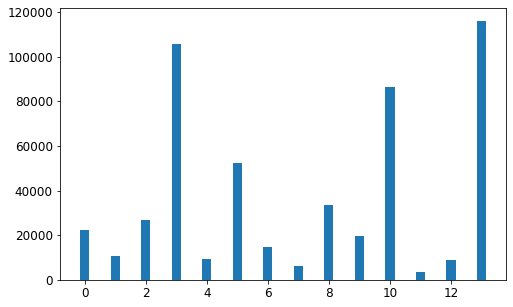

In [3]:
# plot the class distribution
classes = ["No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
            "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion","Pleural Other","Fracture",
            "Support Devices"]

class_counts = []
for cls in classes:
    count = train_file[cls][train_file[cls]== 1.0].count()
    class_counts.append(count)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':12})
plt.figure(figsize=(8,5))
plt.bar(np.arange(14),class_counts, width = 0.3)

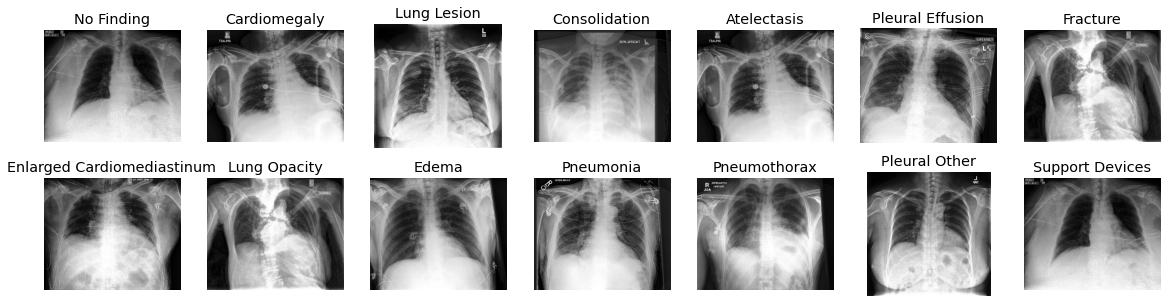

In [4]:
# visualize the images 
f, axarr = plt.subplots(2,7, figsize = (20,5))
cnt = 0
for i in range(7):
    for j in range(2):
        path = (train_file["Path"][train_file[classes[cnt]]== 1.0]).values.tolist()[0]
        img = Image.open(path)
        axarr[j,i].imshow(img, cmap = "gray")
        axarr[j,i].set_axis_off()
        axarr[j,i].set_title(classes[cnt])
        cnt+=1


## Random Sampling Anlysis
See if random smapling to create train and validation maintains the train distribution

<BarContainer object of 10 artists>

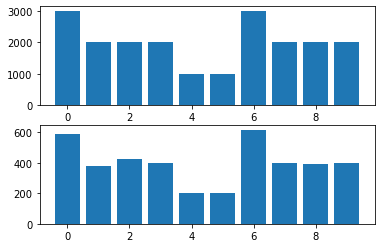

In [35]:
# check how per class data distribution is maintained when the dataset is split into train and validation
import numpy as np
import matplotlib.pyplot as plt
import random

def generate_imbalanced_dist(num_classes = 10, samples = 20000, probs = [0.15,0.1,0.1,0.1,0.05,0.05,0.15,0.1,0.1,0.1]):
    labels = []
    for i in range(num_classes):
        labels.extend([i for k in range(int(probs[i]*samples))])
    random.shuffle(labels)
    return labels

labels = generate_imbalanced_dist()

label, counts = np.unique(labels, return_counts= True)
fig, ax = plt.subplots(2,1)
sampled_labels = np.random.choice(labels, size = int (0.2*len(labels)))
sampled_label, sampled_counts = np.unique(sampled_labels,return_counts=True)
ax[0].bar(label,counts)
ax[1].bar(sampled_label, sampled_counts)

## MURA dataset loader example

In [2]:
## create a dataloader for MURA
import os
import os.path
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader as Dataloader
import torch.utils.data as data
from collections import defaultdict
import pandas as pd 
import torchvision
from torchvision import transforms, models


classes = ["XR_SHOULDER","XR_HUMERUS","XR_FINGER","XR_WRIST","XR_FOREARM","XR_HAND", "XR_ELBOW"]

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def default_loader(path):
    return pil_loader(path)

class MURA(data.Dataset):
    """MURA Dataset Object
    Args:
        root (string): Root directory path of dataset.
        train (bool): load either training set (True) or test set (False) (default: True)
        transform: A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform: A function/transform that takes
            in the target and transforms it.
        seed: random seed for shuffling classes or instances (default=10)
     Attributes:
        samples (list): List of (sample path, class_index) tuples
        targets (list): The class_index value for each image in the dataset
    """

    def __init__(self, root, train=True, transform=None, target_transform=None, num_classes= 7, seed=1):

        
        if train:
           image_folder = os.path.join(root,'train')
           path_list = pd.read_csv(os.path.join(root,'train_image_paths.csv')).values.tolist()
        else:
           image_folder = os.path.join(root,'valid')
           path_list = pd.read_csv(os.path.join(root,'valid_image_paths.csv')).values.tolist()

        self.root = root
        self.loader = default_loader
        self.samples = [pth[0] for pth in path_list]
        self.targets = [classes.index(pth[0].split('/')[2]) for pth in path_list]
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        index = int(index)
        fpath, target = self.samples[index], self.targets[index]
        sample = self.loader(fpath)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [3]:
# use the same standard deviation and mean as that of IMAGENET dataset
from matplotlib.pyplot import axis


train_transform = transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    

train_dataset = MURA(root = "MURA-v1.1",train=True, transform = train_transform)
valid_dataset = MURA(root = "MURA-v1.1",train = False, transform= val_transform)

def oversample(dataset):
    if hasattr(dataset, 'labels'):
        unique_labels, class_counts = np.unique(dataset.labels, return_counts=True)
        max_class = np.argmax(class_counts)
        max_sample = np.max(class_counts)
        sum = 0
        for cls in unique_labels:    
            if cls != max_class:
                add_sample = max_sample - class_counts[cls]
                sum +=add_sample
                idx = np.where(dataset.labels == cls)[0]
                sampled_idx = np.random.choice(idx, size = add_sample) 
                dataset.imgs = np.concatenate((dataset.imgs,dataset.imgs[sampled_idx]), axis = 0)
                dataset.labels = np.concatenate((dataset.labels,dataset.labels[sampled_idx]), axis = 0)
        
    elif hasattr(dataset, 'targets'):
        unique_labels, class_counts = np.unique(dataset.targets, return_counts=True)
        max_class = np.argmax(class_counts)
        max_sample = np.max(class_counts)
        sum = 0
        for cls in unique_labels:    
            if cls != max_class:
                add_sample = max_sample - class_counts[cls]
                sum +=add_sample
                idx = np.where(dataset.targets == cls)[0]
                sampled_idx = np.random.choice(idx, size = add_sample).tolist()

                samples = np.array(dataset.samples)
                targets = np.array(dataset.targets)
                
                samples = np.concatenate((samples,samples[sampled_idx]), axis = 0)
                targets = np.concatenate((targets,targets[sampled_idx]), axis = 0)

                dataset.samples = samples.tolist()
                dataset.targets = targets.tolist()
                
    else:
        raise AssertionError("Unexpected attribute isn't labels or targest!")


print(len(train_dataset.targets))
oversample(train_dataset)
print(len(train_dataset.samples))
print (len(train_dataset.targets))
        
trainloader = Dataloader(train_dataset, batch_size = 64, shuffle = True)
validloader = Dataloader(valid_dataset, batch_size = 64, shuffle = False)



def loader(dataloader, flag = "numpy"):
    features_data = []
    labels_data=[]
    # put features and labels into arrays
    for batch_ix, (batch_x, batch_y) in enumerate(dataloader):
        features_data.extend(batch_x.numpy())
        labels_data.extend(batch_y.numpy())

    if flag == "numpy":
        return np.array(features_data), np.array(labels_data)     
    else:
        return torch.Tensor(features_data), torch.Tensor(labels_data).long()

train_images, train_labels = loader (trainloader)
valid_images, valid_labels = loader (validloader)

36807
68264
68264


## MURA dataset distribution

<BarContainer object of 7 artists>

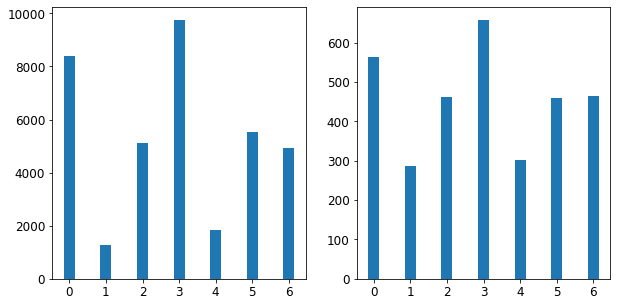

In [3]:
## check MURA class distribution
train_labels_list, train_class_counts = np.unique(train_labels, return_counts=True)
valid_labels_list, valid_class_counts = np.unique(valid_labels, return_counts=True)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':12})
#plt.figure(figsize=(8,5))
#plt.bar(labels,class_counts, width = 0.3)
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].bar(train_labels_list,train_class_counts, width = 0.3)
ax[1].bar(valid_labels_list,valid_class_counts, width = 0.3)


# Kidney Segmentation Dataset 

### Custom Dataloader for Kidney Segmentation Dataset ###

In [18]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from collections import namedtuple
import numpy
import PIL.Image as Image
from utils import *
import math
from exr_data import readEXR
import random
import pdb

class LiverSegDataset(Dataset):


    def __init__(self, root_dir, train = True, flip=False, resize = None, scale= None, crop=None):

        # Based on https://github.com/mcordts/cityscapesScripts
        Seg_classes = namedtuple('Class', ['name', 'train_id','color', 'color_name'])
        self.classes = [
        Seg_classes('liver', 0, (0, 0, 255), 'blue'),
        Seg_classes('stomach', 1, (255, 0, 0), 'red'),
        Seg_classes('abdominal wall', 2, (0, 255, 0), 'green'),
        Seg_classes('gallbladder', 3, (0, 255, 255), 'cyan'),
        Seg_classes('ligament', 4, (255, 0, 255), 'magenta')]

        self.colors = [c.color for c in self.classes ]
        self.train_ids = [c.train_id for c in self.classes]
        self.color_to_train_ids = dict(zip(self.colors,self.train_ids))
        self.train_ids_to_color = dict(zip(self.train_ids,self.colors))


        self.flip = flip
        self.scale = scale
        self.resize = resize
        self.crop = crop

        self.root_dir = root_dir
        self.image_dir = 'translation_random_views/random_views'
        self.mask_dir = 'segmentation_random_views/random_views'
        self.depth_map_dir = 'depth_random_views/random_views'
        
        self.transform_x = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],
            std=[0.5,0.5,0.5])
        ])
        self.transform_y = transforms.Compose([
            transforms.ToTensor()
        ])

        self.transform_z = transforms.Compose([          
            transforms.ToTensor()
        ])
      
        ### use this if you want to directly load from filepath
       
        # self.image_files = list()
        # for (dirpath, dirnames, filenames) in os.walk(os.path.join(self.root_dir, self.image_dir)):
        #     self.image_files += [os.path.join(dirpath, file) for file in filenames if file.endswith('.png')]
        # self.image_files.sort()

        # self.mask_files = list()
        # for (dirpath, dirnames, filenames) in os.walk(os.path.join(self.root_dir, self.mask_dir)):
        #     self.mask_files += [os.path.join(dirpath, file) for file in filenames if file.endswith('.png')]
        # self.mask_files.sort()


        # self.depth_files = list()
        # for (dirpath, dirnames, filenames) in os.walk(os.path.join(self.root_dir, self.depth_map_dir)):
        #     self.depth_files += [os.path.join(dirpath, file) for file in filenames if file.endswith('.exr')]
        # self.depth_files.sort()

        if train:
            train_files = (numpy.load('train_files.npy', allow_pickle='TRUE')).item()
            self.image_files = train_files['images'].tolist()
            self.mask_files = train_files['masks'].tolist()
            self.depth_files = train_files['depths'].tolist()

        else:
            test_files = (numpy.load('test_files.npy', allow_pickle='TRUE')).item()
            self.image_files = test_files['images'].tolist()
            self.mask_files = test_files['masks'].tolist()
            self.depth_files = test_files['depths'].tolist()


        
        ## clip the list of images to debug
        # self.image_files = self.image_files[0:1000]
        # self.mask_files = self.mask_files[0:1000]
        # self.depth_files = self.depth_files[0:1000]

        

    def encode_target(self, target):

        c,h,w = target.shape
        new_mask = torch.empty(h, w, dtype=torch.long)
        for k in self.color_to_train_ids:
            # Get all indices for current class
            idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
            validx = (idx.sum(0) == 3)  # Check that all channels match
            new_mask[validx] = torch.tensor(self.color_to_train_ids[k], dtype=torch.long)
     
        return new_mask

  
    def decode_target(self, target):
        h,w = target.shape
        
        new_mask = torch.zeros(h, w, 3, dtype=torch.uint8)
        for k in self.train_ids_to_color:
            # Get all indices for current class
            idx = (target==torch.tensor(k, dtype=torch.long))
            new_mask[idx] = torch.tensor(self.train_ids_to_color[k], dtype=torch.uint8)

        # new_mask = new_mask.permute(2,0,1)
        return new_mask


        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_fn = os.path.join(self.root_dir, self.image_dir, self.image_files[idx])
        mask_fn = os.path.join(self.root_dir, self.mask_dir, self.image_files[idx])

        image = Image.open(self.image_files[idx]).convert('RGB')
        mask = Image.open(self.mask_files[idx]).convert('RGB')
        depth = readEXR(self.depth_files[idx])
       
     

        image, mask, depth = preprocess(image, mask, depth, transform= self.transform_x, target_transform= self.transform_y, 
                            depth_transform = self.transform_z , scale = self.scale, flip= self.flip, resize= self.resize, crop= self.crop)
        
        mask = self.encode_target(mask)
       
        return image, mask, depth


def preprocess(image, mask, depth= None, transform = None, target_transform = None, depth_transform = None, flip=False, resize = None, scale=None, crop=None):
    if flip:
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            if depth is not None:
                depth = depth.transpose(Image.FLIP_LEFT_RIGHT)

    
    if scale :
        w, h = image.size
        rand_log_scale = math.log(scale[0], 2) + random.random() * (math.log(scale[1], 2) - math.log(scale[0], 2))
        random_scale = math.pow(2, rand_log_scale)
        new_size = (int(round(w * random_scale)), int(round(h * random_scale)))
        image = image.resize(new_size, Image.ANTIALIAS)
        mask = mask.resize(new_size, Image.NEAREST)
        if depth is not None:
            depth = depth.resize(new_size, Image.NEAREST)

    if resize:
        image = image.resize((resize,resize), Image.ANTIALIAS)
        mask = mask.resize((resize,resize), Image.NEAREST)
        
        if depth is not None:
            depth = depth.resize((resize,resize), Image.NEAREST)


    if transform:
        image = transform(image)
    if target_transform:
        mask = 255 * target_transform(mask)

    if depth is not None:
        if depth_transform:
            depth = target_transform(depth)

    mask = mask.long()
    
    if crop:
        h, w = image.shape[1], image.shape[2]
        pad_tb = max(0, crop[0] - h)
        pad_lr = max(0, crop[1] - w)
        image = torch.nn.ZeroPad2d((0, pad_lr, 0, pad_tb))(image)
        mask = torch.nn.ConstantPad2d((0, pad_lr, 0, pad_tb), 255)(mask)
        if depth is not None:
            depth = torch.nn.ConstantPad2d((0, pad_lr, 0, pad_tb), 255)(depth)  

        h, w = image.shape[1], image.shape[2]
        i = random.randint(0, h - crop[0])
        j = random.randint(0, w - crop[1])
        image = image[:, i:i + crop[0], j:j + crop[1]]
        mask = mask[i:i + crop[0], j:j + crop[1]]
        if depth is not None:
            depth = depth[i:i + crop[0], j:j + crop[1]]  

    if depth is not None:
        return image, mask, depth
    else:
        return image, mask, 0




## Load the imgs, mask, and depth ##

In [19]:
dataset = LiverSegDataset("data/liver_seg_dataset")
print (len(dataset))

imgs = []
masks = []
depths = []
for i, (img, m, d) in enumerate(dataset):
    imgs.append(img)
    masks.append(m)
    depths.append(d)
    if i > 100:
        break
    
print (i)

18900


/home/bidur/miniconda3/envs/deeplearning-pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


101


### Visualize image, mask and depth

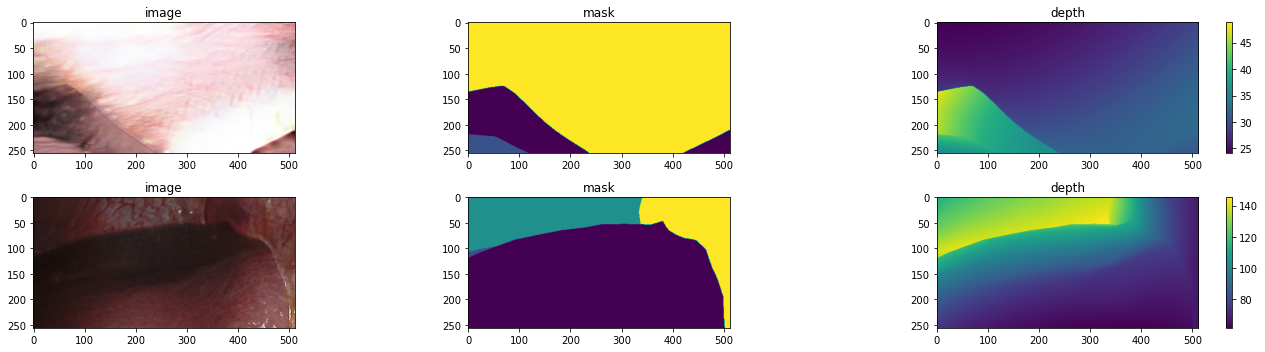

In [20]:
import matplotlib.pyplot as plt
# visualize the images 
f, axarr = plt.subplots(2,3, figsize = (20,5))
cnt = 0
for i in range(2):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    axarr[i,0].imshow(invTrans(imgs[i]).permute(1,2,0))
    axarr[i,0].set_title("image")

    axarr[i,1].imshow(masks[i])
    axarr[i,1].set_title("mask")
    
    
    d = axarr[i,2].imshow(depths[i].squeeze(0))
    axarr[i,2].set_title("depth")
    plt.colorbar(d, ax=axarr[i, 2])

    plt.tight_layout()


In [7]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from collections import namedtuple
import numpy
import PIL.Image as Image
from utils import *
import math
from exr_data import readEXR
import random
import pdb

class LiverSegDataset(Dataset):


    def __init__(self, root_dir, flip=False, resize = None, scale= None, crop=None):

        # Based on https://github.com/mcordts/cityscapesScripts
        Seg_classes = namedtuple('Class', ['name', 'train_id','color', 'color_name'])
        self.classes = [
        Seg_classes('liver', 0, (0, 0, 255), 'blue'),
        Seg_classes('stomach', 1, (255, 0, 0), 'red'),
        Seg_classes('abdominal wall', 2, (0, 255, 0), 'green'),
        Seg_classes('gallbladder', 3, (0, 255, 255), 'cyan'),
        Seg_classes('ligament', 4, (255, 0, 255), 'magenta')]

        self.colors = [c.color for c in self.classes ]
        self.train_ids = [c.train_id for c in self.classes]
        self.color_to_train_ids = dict(zip(self.colors,self.train_ids))
        self.train_ids_to_color = dict(zip(self.train_ids,self.colors))


        self.flip = flip
        self.scale = scale
        self.resize = resize
        self.crop = crop

        self.root_dir = root_dir
        self.image_dir = 'translation_random_views/random_views'
        self.mask_dir = 'segmentation_random_views/random_views'
        self.depth_map_dir = 'depth_random_views/random_views'
        
        self.transform_x = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],
            std=[0.5,0.5,0.5])
        ])
        self.transform_y = transforms.Compose([
            transforms.ToTensor()
        ])

        self.transform_z = transforms.Compose([          
            transforms.ToTensor()
        ])
      
       
        self.image_files = list()
        for (dirpath, dirnames, filenames) in os.walk(os.path.join(self.root_dir, self.image_dir)):
            self.image_files += [os.path.join(dirpath, file) for file in filenames if file.endswith('.png')]
        self.image_files.sort()
        self.image_files = np.array(self.image_files)

        self.mask_files = list()
        for (dirpath, dirnames, filenames) in os.walk(os.path.join(self.root_dir, self.mask_dir)):
            self.mask_files += [os.path.join(dirpath, file) for file in filenames if file.endswith('.png')]
        self.mask_files.sort()
        self.mask_files = np.array(self.mask_files)


        self.depth_files = list()
        for (dirpath, dirnames, filenames) in os.walk(os.path.join(self.root_dir, self.depth_map_dir)):
            self.depth_files += [os.path.join(dirpath, file) for file in filenames if file.endswith('.exr')]
        self.depth_files.sort()
        self.depth_files = np.array(self.depth_files)


        all_indices = set(np.arange(len(self.image_files)))
        #print(all_indices)
        random.seed(0)  #every time set the same seed
        test_ratio = 0.1
        test_indices = random.sample(all_indices, int(test_ratio*len(all_indices)))
        train_indices = np.setdiff1d(list(all_indices), test_indices)

        train_files = {'images': self.image_files[train_indices], 'masks': self.mask_files[train_indices], 'depths': self.depth_files[train_indices]}
        test_files = {'images': self.image_files[test_indices], 'masks': self.mask_files[test_indices], 'depths': self.depth_files[test_indices]}

        np.save('train_files.npy', train_files)
        np.save('test_files.npy',test_files)

        

        ## clip the list of images to debug
        # self.image_files = self.image_files[0:1000]
        # self.mask_files = self.mask_files[0:1000]
        # self.depth_files = self.depth_files[0:1000]

        

    def encode_target(self, target):

        c,h,w = target.shape
        new_mask = torch.empty(h, w, dtype=torch.long)
        for k in self.color_to_train_ids:
            # Get all indices for current class
            idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
            validx = (idx.sum(0) == 3)  # Check that all channels match
            new_mask[validx] = torch.tensor(self.color_to_train_ids[k], dtype=torch.long)
     
        return new_mask

  
    def decode_target(self, target):
        h,w = target.shape
        
        new_mask = torch.zeros(h, w, 3, dtype=torch.uint8)
        for k in self.train_ids_to_color:
            # Get all indices for current class
            idx = (target==torch.tensor(k, dtype=torch.long))
            new_mask[idx] = torch.tensor(self.train_ids_to_color[k], dtype=torch.uint8)

        # new_mask = new_mask.permute(2,0,1)
        return new_mask


        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_fn = os.path.join(self.root_dir, self.image_dir, self.image_files[idx])
        mask_fn = os.path.join(self.root_dir, self.mask_dir, self.image_files[idx])

        image = Image.open(self.image_files[idx]).convert('RGB')
        mask = Image.open(self.mask_files[idx]).convert('RGB')
        depth = readEXR(self.depth_files[idx])
       
     

        image, mask, depth = preprocess(image, mask, depth, transform= self.transform_x, target_transform= self.transform_y, 
                            depth_transform = self.transform_z , scale = self.scale, flip= self.flip, resize= self.resize, crop= self.crop)
        
        mask = self.encode_target(mask)
       
        return image, mask, depth


def preprocess(image, mask, depth= None, transform = None, target_transform = None, depth_transform = None, flip=False, resize = None, scale=None, crop=None):
    if flip:
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            if depth is not None:
                depth = depth.transpose(Image.FLIP_LEFT_RIGHT)

    
    if scale :
        w, h = image.size
        rand_log_scale = math.log(scale[0], 2) + random.random() * (math.log(scale[1], 2) - math.log(scale[0], 2))
        random_scale = math.pow(2, rand_log_scale)
        new_size = (int(round(w * random_scale)), int(round(h * random_scale)))
        image = image.resize(new_size, Image.ANTIALIAS)
        mask = mask.resize(new_size, Image.NEAREST)
        if depth is not None:
            depth = depth.resize(new_size, Image.NEAREST)

    if resize:
        image = image.resize((resize,resize), Image.ANTIALIAS)
        mask = mask.resize((resize,resize), Image.NEAREST)
        
        if depth is not None:
            depth = depth.resize((resize,resize), Image.NEAREST)


    if transform:
        image = transform(image)
    if target_transform:
        mask = 255 * target_transform(mask)

    if depth is not None:
        if depth_transform:
            depth = target_transform(depth)

    mask = mask.long()
    
    if crop:
        h, w = image.shape[1], image.shape[2]
        pad_tb = max(0, crop[0] - h)
        pad_lr = max(0, crop[1] - w)
        image = torch.nn.ZeroPad2d((0, pad_lr, 0, pad_tb))(image)
        mask = torch.nn.ConstantPad2d((0, pad_lr, 0, pad_tb), 255)(mask)
        if depth is not None:
            depth = torch.nn.ConstantPad2d((0, pad_lr, 0, pad_tb), 255)(depth)  

        h, w = image.shape[1], image.shape[2]
        i = random.randint(0, h - crop[0])
        j = random.randint(0, w - crop[1])
        image = image[:, i:i + crop[0], j:j + crop[1]]
        mask = mask[i:i + crop[0], j:j + crop[1]]
        if depth is not None:
            depth = depth[i:i + crop[0], j:j + crop[1]]  

    if depth is not None:
        return image, mask, depth
    else:
        return image, mask, 0


dataset = LiverSegDataset("data/liver_seg_dataset")